<h1 align="center">Walmart Demand Forecasting</h1>

<h4 align="center">Domain: Demand Forecasting</h4>


---
###Description



This dataset provides historical sales data for 45 Walmart stores located in different regions. The dataset covers 2010-02-05 to 2012-11-01 and includes various economic factors and holiday information that might affect sales. Walmart seeks to improve sales and demand prediction accuracy using machine learning.

Key challenges include modeling the impact of promotional markdown events the week of major holidays like the Super Bowl, Labor Day, Thanksgiving, and Christmas, which significantly influence sales. These are weighted five times higher in the evaluation than non-holiday weeks. The project aims to enhance forecasting capabilities amidst fluctuating demand and economic conditions.
<br><br>
Dataset Name: Walmart Dataset
<br><br>
Source: The dataset is sourced from Kaggle [link](https://www.kaggle.com/datasets/yasserh/walmart-dataset/data)



---
###Objective

The goal of this analysis is to:

- Understand the Dataset
- Clean the Dataset
- Develop Regression models to accurately predict future sales while understanding feature importance
- Evaluate the models

In understanding the key factors that influence sales at Walmart stores, we may develop a model that accurately predicts future sales. This model can help Walmart optimize inventory management, staffing, and marketing strategies but at the same time interpretability and understanding feature impacts may be more critical.

---
###Strategic Plan of Action

We aim to meet the objective by following these necessary steps:

- Data Exploration
- Data Pre-processing
- Exploratory Data Analysis (EDA)
- Feature Selection
- Model Selection
- Hyperparameter Tuning
- Evaluation

---
###Explanation of Each Column

| Column Name       | Description                                              | Data Type | Notes                               |
|-------------------|----------------------------------------------------------|-----------|-------------------------------------|
| Store             | Unique identifier for each store                         | Integer | Distinguishes sales data across different Walmart stores |
| Date              | Date of the sales data                                   | Object to be converted to datetime64[ns]  | Indicates the week of sales |
| Weekly_Sales      | Sales recorded for the given store for that week | Float | Target variable for the predictive model |
| Holiday_Flag         | Indicator for whether the week includes a major holiday  | Integer | Affects sales patterns 1=Holiday week 0=Non-hoiday week|
| Temperature       | Average temperature for the region during that week      | Float | Provides insights into how weather conditions impact sales |
| Fuel_Price        | Cost of fuel in the region for that week                 | Float | Can influence consumer spending behavior |
| CPI               | Consumer Price Index                                     | Float | Represents the relative cost of consumer goods and services, impacting purchasing power |
| Unemployment      | Unemployment rate in the region for that week            | Float | Higher unemployment rates might negatively affect sales |
| Year          | Year of the sales data                                   | Integer   | Extracted from the Date column after conversion |
| Month         | Month of the sales data                                  | Integer   | Extracted from the Date column after conversion |
| Day           | Day of the sales data                                    | Integer   | Extracted from the Date column after conversion |
| WeekOfYear    | ISO week date system: week number of the sales data                        | Integer   | Extracted from the Date column after conversion |

---
###Data Exploration

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif, f_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform, stats
from joblib import dump, load
import joblib
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings
from sklearn.compose import ColumnTransformer
from matplotlib.ticker import FuncFormatter


df = pd.read_csv('Walmart.csv')

In [ ]:
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


---

The dataset is composed of 6435 rows and 8 columns.

---

####Dataframe Information - dtypes

In [ ]:
# Dataframe Information
print("Dataframe Information:")
print(df.info())

Dataframe Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB
None


---

We will need to extract Year, Month, WeekofYear, and Day from the Date column after a conversion to datetime format to better understand the dataset. Conversion helps capture temporal patterns and seasonality that can improve model performance.

---

####Convert Date

In [ ]:
# Date is 2010-02-05 object-we need to convert it to datetime format in order to extract later
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y') # converts object(string) format to datetime format

# Extract year, month, day, week of the year and day of the week
df['Year'] = df.Date.dt.year
df['Month'] = df.Date.dt.month
df['Day'] = df.Date.dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['Weekday'] = (df['Date'].dt.dayofweek + 1) % 7  # Sunday=0, Saturday=6


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
 8   Year          6435 non-null   int32         
 9   Month         6435 non-null   int32         
 10  Day           6435 non-null   int32         
 11  WeekOfYear    6435 non-null   UInt32        
 12  Weekday       6435 non-null   int32         
dtypes: UInt32(1), datetime64[ns](1), float64(5), int32(4), int64(2)
memory usage: 534.3 KB
None


---

To better understand the dataset we needed to extract Year, Month, WeekofYear,Day and Weekday from the Date column after a conversion to datetime format.

---

####Descriptive Statistics

In [ ]:
# Descriptive statistics
print("Descriptive Statistics:")
print(df.describe())
print()

Descriptive Statistics:
             Store                 Date  Weekly_Sales  Holiday_Flag  \
count  6435.000000                 6435  6.435000e+03   6435.000000   
mean     23.000000  2011-06-17 00:00:00  1.046965e+06      0.069930   
min       1.000000  2010-02-05 00:00:00  2.099862e+05      0.000000   
25%      12.000000  2010-10-08 00:00:00  5.533501e+05      0.000000   
50%      23.000000  2011-06-17 00:00:00  9.607460e+05      0.000000   
75%      34.000000  2012-02-24 00:00:00  1.420159e+06      0.000000   
max      45.000000  2012-10-26 00:00:00  3.818686e+06      1.000000   
std      12.988182                  NaN  5.643666e+05      0.255049   

       Temperature   Fuel_Price          CPI  Unemployment         Year  \
count  6435.000000  6435.000000  6435.000000   6435.000000  6435.000000   
mean     60.663782     3.358607   171.578394      7.999151  2010.965035   
min      -2.060000     2.472000   126.064000      3.879000  2010.000000   
25%      47.460000     2.933000   13

---

- Store has a mean of 23 suggesting the dataset covers a range of stores with each contributing around the same on average. It is a distribution that indicates the sales data is fairly represented across the 45 stores that are included.

- Target variable: Weekly_Sales has a mean ~1,046,965 dollars with a standard deviation of ~$564,366. The range is 209,986-3,818,686 suggesting a broad range of variability/weekly sales. The diversity here across the different weeks may be influenced by other factors.

- Holiday_Flag shows a mean of ~7% of sales are conducted on a holiday with a low .255 standard deviation which implies it is consistent but somewhat of a minor impact on sales compared to the non-holiday weeks.

- Temperature and Economic factors: The average temperature is ~60.66 degrees and may help in understanding seasonal variations in consumer behiavior and/or sales patterns. Fuel_Price has a mean of ~3.36, CPI is ~171.58, Unemployment ~8.

- Date Components: Month, Day and WeekOfYear suggests the average peak sales are around mid June, the 25th week of the year.

---

####Unique Values

In [ ]:
# Check for unique values (Store and Holiday_Flag expected to have unique identifier; Year, Month, day, WeekOfYear, Weekday derived from Date
# are used for time-series analysis, trends, patterns, etc so need to ensure uniqueness here. Other columns are
# continuous or categorical that do not require unique check)
columns_to_check_unique = ['Store', 'Holiday_Flag','Year', 'Month', 'Day', 'WeekOfYear', 'Weekday']
for col in columns_to_check_unique:
    unique_values = df[col].unique()
    print(f"Unique values in '{col}':")
    print(unique_values)
    print()

Unique values in 'Store':
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]

Unique values in 'Holiday_Flag':
[0 1]

Unique values in 'Year':
[2010 2011 2012]

Unique values in 'Month':
[ 2  3  4  5  6  7  8  9 10 11 12  1]

Unique values in 'Day':
[ 5 12 19 26  2  9 16 23 30  7 14 21 28  4 11 18 25  6 13 20 27  3 10 17
 24  1  8 15 22 29 31]

Unique values in 'WeekOfYear':
<IntegerArray>
[ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,  1,  2,  3,  4]
Length: 52, dtype: UInt32

Unique values in 'Weekday':
[5]



---

We check for unique values. Store and Holiday_Flag are expected to have unique identifier. Year, Month, Day, WeekOfYear, Weekday derived from Date are used for time-series analysis, trends, patterns, etc so need to ensure uniqueness here. Other columns are continuous or categorical that do not require unique check.
<br>
<br>

As expected, there are 45 stores, 3 years, 12 months, 31 days, 52 weeks, and 2 unique values in holiday_flag column represented in the dataset. Because Friday (5) is the only value in Weekday, this can be interpreted that sales data is recorded weekly on Fridays and we will at some point disregard it/drop it along with Day, as there's no insightful information.

---

####Binary Value Counts

In [ ]:
holiday_flag_counts_per_week = df.groupby(['Year', 'WeekOfYear'])['Holiday_Flag'].max().groupby('Year').sum()

print(holiday_flag_counts_per_week)

Year
2010    4
2011    4
2012    2
Name: Holiday_Flag, dtype: int64


---
Holiday Events 2010
- Super Bowl: 12-Feb-10
- Labour Day: 10-Sep-10
- Thanksgiving: 26-Nov-10
- Christmas: 31-Dec-10

Holiday Events 2011:
- Super Bowl: 11-Feb-11
- Labour Day: 9-Sep-11
- Thanksgiving: 25-Nov-11
- Christmas: 30-Dec-11

Holiday Events 2012:
- Super Bowl:  10-Feb-12
- Labour Day: 7-Sep-12

Dataset covers sales from 2010-02-05 to 2012-11-01.

---

---
###Data Preprocessing

####Missing Values

In [ ]:
# Check for missing values
missing_values = df.isnull().sum().sum()  # Total number of missing values in the DataFrame
print()
if missing_values == 0:
    print("There are no missing values in the DataFrame.")
else:
    print(f"There are {missing_values} missing values in the DataFrame.")
print()


There are no missing values in the DataFrame.



---
There are no missing values in the dataframe.

---

#### Duplicates

In [ ]:
#Check for duplicates
duplicate_rows = df[df.duplicated()]
if not duplicate_rows.empty:
    print("Duplicate rows found in the DataFrame:")
    print(duplicate_rows)
else:
    print("No duplicate rows found in the DataFrame.")
print()

No duplicate rows found in the DataFrame.



---
There are no duplicate rows found in the dataframe.

---

####Identify Outliers

In [ ]:
# Check for outliers - numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Exclude 'Holiday_Flag' from the numerical columns as it's already binary
numerical_cols = [col for col in numerical_cols if col != 'Holiday_Flag']

# Using IQR method for each numerical column
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    if not outliers.empty:
        print(f"Column '{col}' has {len(outliers)} outliers according to IQR method.")
print()

Column 'Weekly_Sales' has 34 outliers according to IQR method.
Column 'Temperature' has 3 outliers according to IQR method.
Column 'Unemployment' has 481 outliers according to IQR method.



---
- Column 'Weekly_Sales' has 34 outliers according to IQR method.
- Column 'Temperature' has 3 outliers according to IQR method.
- Column 'Unemployment' has 481 outliers according to IQR method.

---

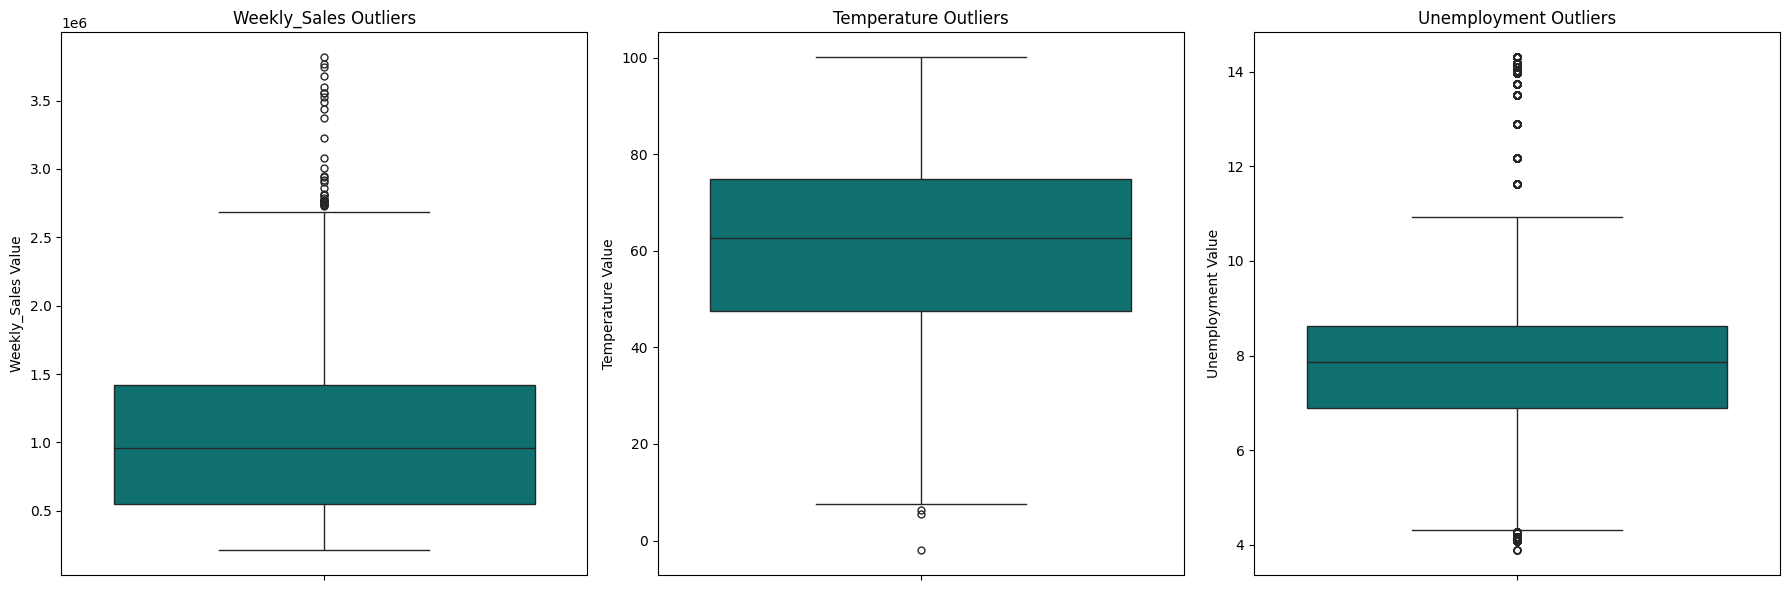

In [ ]:
# Function to create vertical box plots
def plot_box(column_name, ax, y_label, title):
    sns.boxplot(y=df[column_name], ax=ax, color='teal', fliersize=5)
    ax.set_xlabel('')
    ax.set_ylabel(y_label)
    ax.set_title(title)

# List of columns with outliers
outlier_columns = ['Weekly_Sales', 'Temperature', 'Unemployment']

# Plot all in one row (adjust the number of subplots based on the number of columns with outliers)
fig, axs = plt.subplots(1, len(outlier_columns), figsize=(18, 6))

# Plot each column if it has outliers
for ax, column in zip(axs, outlier_columns):
    plot_box(column, ax, f'{column} Value', f'{column} Outliers')

plt.tight_layout()
plt.show()


---
- Temperature and Unemployment we will remove to improve model accuracy and stability. Extreme values in these columns, which might reflect rare or erroneous data points, could distort analysis and predictions.

- We will look to reason and plot the Weekly Sales 34 outliers according to IQR method.

---

####Outlier Removal

In [ ]:
def detect_outliers_iqr(df, column):
    """Function to calculate lower and upper bounds for outliers using IQR method."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Identify outliers
temp_lower, temp_upper = detect_outliers_iqr(df, 'Temperature')
ue_lower, ue_upper = detect_outliers_iqr(df, 'Unemployment')

# Remove outliers from Temperature and Unemployment
df_filtered_temp = df[(df['Temperature'] >= temp_lower) & (df['Temperature'] <= temp_upper)]
df_filtered_ue = df_filtered_temp[(df_filtered_temp['Unemployment'] >= ue_lower) & (df_filtered_temp['Unemployment'] <= ue_upper)]

# Print results
print(f"Original number of rows: {len(df)}")
print(f"Number of rows after removing outliers: {len(df_filtered_ue)}")

Original number of rows: 6435
Number of rows after removing outliers: 5951


---
From 6435 rows to 5951 rows after removing outliers in Temperature and Unemployment. By excluding these outliers, we aim to create a more consistent dataset that accurately represents typical temperature and unemployment conditions, leading to more reliable and robust model performance.

---

####Outlier Plot of Weekly_Sales

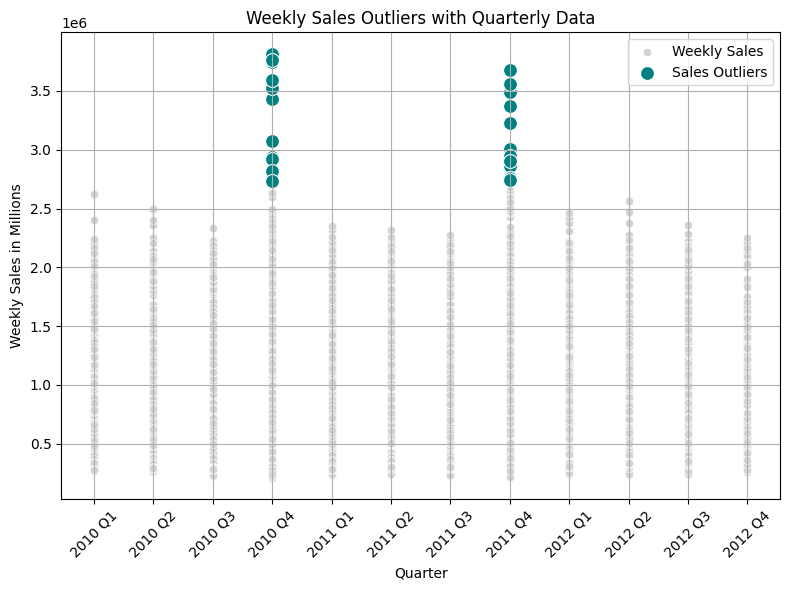

In [ ]:
# Calculate the IQR bounds for Weekly Sales
Q1 = df['Weekly_Sales'].quantile(0.25)
Q3 = df['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1
upper_bound_sales = Q3 + 1.5 * IQR

# Temporarily add the 'Quarter' column for plotting
df_temp = df.copy()
df_temp['Quarter'] = df_temp.apply(lambda row: f"{int(row['Year'])} Q{int((row['Month'] - 1) // 3) + 1}", axis=1)
'''
Create new column Quarter, apply function, lamda row defines anonymous function to compute quarter for ea row
row['Year'] gets year in current row, ((row['Month'] gets month in row
- 1) // 3) + 1 gets quarter number January (Month 1) - March (Month 3) is Q1 and so on
+ 1 adjusts result to omatch standard quarter labelling (Q1, Q2, Q3, Q4)
'''
# Ensure 'Quarter' column is also added to sales_outliers for consistency in plotting
sales_outliers = df[df['Weekly_Sales'] > upper_bound_sales].copy()
sales_outliers['Quarter'] = sales_outliers.apply(lambda row: f"{int(row['Year'])} Q{int((row['Month'] - 1) // 3) + 1}", axis=1)

plt.figure(figsize=(8, 6))

# Plot Weekly Sales
sns.scatterplot(x='Quarter', y='Weekly_Sales', data=df_temp, color='lightgray', label='Weekly Sales')

# Plotting outliers
sales_outliers_temp = df_temp[df_temp['Weekly_Sales'] > upper_bound_sales]
sns.scatterplot(x='Quarter', y='Weekly_Sales', data=sales_outliers_temp, color='teal', label='Sales Outliers', s=100)

plt.xlabel('Quarter')
plt.ylabel('Weekly Sales in Millions')
plt.title('Weekly Sales Outliers with Quarterly Data')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Clean up: Remove temporary columns
df_temp = df_temp.drop(columns=['Quarter'] + [col for col in df_temp if col.startswith('Month_')])

---
Column 'Weekly_Sales' has 34 outliers that appear to be tied to the Thanksgiving/Christmas shopping season in November/December suggesting this is when sales spike and are to be expected. This reinforces the known that weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. For this reason, we will keep the outliers.

---

####Sales Analysis

In [ ]:
# Extract additional time-related features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['Day'] = df.Date.dt.day

# Function to categorize seasons based on the specific date ranges
def get_season(date):
    if pd.Timestamp(date.year, 3, 19) <= date <= pd.Timestamp(date.year, 6, 20):
        return 'Spring'
    elif pd.Timestamp(date.year, 6, 21) <= date <= pd.Timestamp(date.year, 9, 21):
        return 'Summer'
    elif pd.Timestamp(date.year, 9, 22) <= date <= pd.Timestamp(date.year, 12, 20):
        return 'Fall'
    else:
        return 'Winter'

# Apply get_season to each row in the DataFrame
df['Season'] = df['Date'].apply(get_season)

# Print out any dates categorized as 'Unknown'
unknown_dates = df[df['Season'].isna()]['Date'].tolist()
if unknown_dates:
    print("Dates categorized as Unknown:")
    for date in unknown_dates:
        print(date)
else:
    print("No dates categorized as Unknown.")


No dates categorized as Unknown.


---
Here, we extract additional time-related features (year, month, week, day) from the Date column in the DataFrame, categorizing each date into seasons based on defined date ranges, and check for any dates that could not be categorized.

---

In [ ]:
# Define the function to plot and analyze data for each year
def plot_and_analyze_yearly_data(year):
    yearly_data = df[df['Year'] == year]

    # Plotting
    fig, axs = plt.subplots(3, 3, figsize=(18, 18))
    fig.suptitle(f'Sales Analysis by Year {year}', fontsize=20, y=0.97)  # Adjust title position

    # Holidays effect on weekly sales
    sns.boxplot(x='Holiday_Flag', y='Weekly_Sales', data=yearly_data, hue='Holiday_Flag', palette=['#008080', '#5f9ea0'], ax=axs[0, 0])
    axs[0, 0].set_title(f'{year} - Holidays Effect on Weekly Sales in Million(s)')
    axs[0, 0].set_xlabel('Holiday_Flag')
    if axs[0, 0].legend_ is not None:
        axs[0, 0].legend_.remove()

    # Sales by Season
    season_sales = yearly_data.groupby('Season')['Weekly_Sales'].sum().reset_index()
    max_season = season_sales.loc[season_sales['Weekly_Sales'].idxmax()]
    sns.barplot(x='Season', y='Weekly_Sales', data=season_sales, hue='Season', palette='winter', ax=axs[0, 1])
    axs[0, 1].set_title(f'{year} - Total Sales by Season in 100 Million(s)')
    if axs[0, 1].legend_ is not None:
        axs[0, 1].legend_.remove()
    axs[0, 1].text(0.5, 0.5, f'Most Sales: {max_season["Season"]} Season\nTotal Sales: {max_season["Weekly_Sales"]:.2f}', ha='center', va='center', transform=axs[0, 1].transAxes, fontsize=12, bbox=dict(facecolor='lightblue', alpha=0.5))

    # Sales by Month
    month_sales = yearly_data.groupby('Month')['Weekly_Sales'].sum().reset_index()
    max_month = month_sales.loc[month_sales['Weekly_Sales'].idxmax()]
    sns.barplot(x='Month', y='Weekly_Sales', data=month_sales, hue='Month', palette='winter', ax=axs[0, 2])
    axs[0, 2].set_title(f'{year} - Total Sales by Month in 100 Million(s)')
    if axs[0, 2].legend_ is not None:
        axs[0, 2].legend_.remove()
    axs[0, 2].text(0.5, 0.5, f'Most Sales: Month {int(max_month["Month"])}\nTotal Sales: {max_month["Weekly_Sales"]:.2f}', ha='center', va='center', transform=axs[0, 2].transAxes, fontsize=12, bbox=dict(facecolor='lightblue', alpha=0.5))

    # Store with most sales
    store_sales = yearly_data.groupby('Store')['Weekly_Sales'].sum().reset_index()
    max_store = store_sales.loc[store_sales['Weekly_Sales'].idxmax()]
    axs[0, 2].text(0.5, 0.3, f'Most Sales: Store {int(max_store["Store"])}\nTotal Sales: {max_store["Weekly_Sales"]:.2f}', ha='center', va='center', transform=axs[0, 2].transAxes, fontsize=12, bbox=dict(facecolor='lightblue', alpha=0.5))

    # Clear remaining subplots if necessary
    for ax in axs.flat:
        if not ax.has_data():
            ax.remove()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Fine-tune spacing
    plt.show()

    # Analysis in sentence form
    holiday_effect = yearly_data.groupby('Holiday_Flag')['Weekly_Sales'].mean()
    season_sales = yearly_data.groupby('Season')['Weekly_Sales'].sum().sort_values(ascending=False)
    month_sales = yearly_data.groupby('Month')['Weekly_Sales'].sum().sort_values(ascending=False)

    store_sales = yearly_data.groupby('Store')['Weekly_Sales'].sum().reset_index()
    max_store = store_sales.loc[store_sales['Weekly_Sales'].idxmax()]

    print(f"Year {year} Analysis:")
    print(f"1. Holidays affect weekly sales, with the average sales during holidays being {holiday_effect[1]:.2f} compared to {holiday_effect[0]:.2f} on non-holidays.")
    print(f"2. The season with the most sales is {season_sales.index[0]} with total sales of {season_sales.iloc[0]:.2f}.")
    print(f"3. The month with the most sales is {month_sales.index[0]} with total sales of {month_sales.iloc[0]:.2f}.")
    print(f"4. The store with the most sales is Store {int(max_store['Store'])} with total sales of {max_store['Weekly_Sales']:.2f}.")
    print("\n")


---
This function plots and analyzes data for each year in the dataset. It looks at Holidays effect on weekly sales, sales by season, sales by month, and identifies the store with the most sales.

---

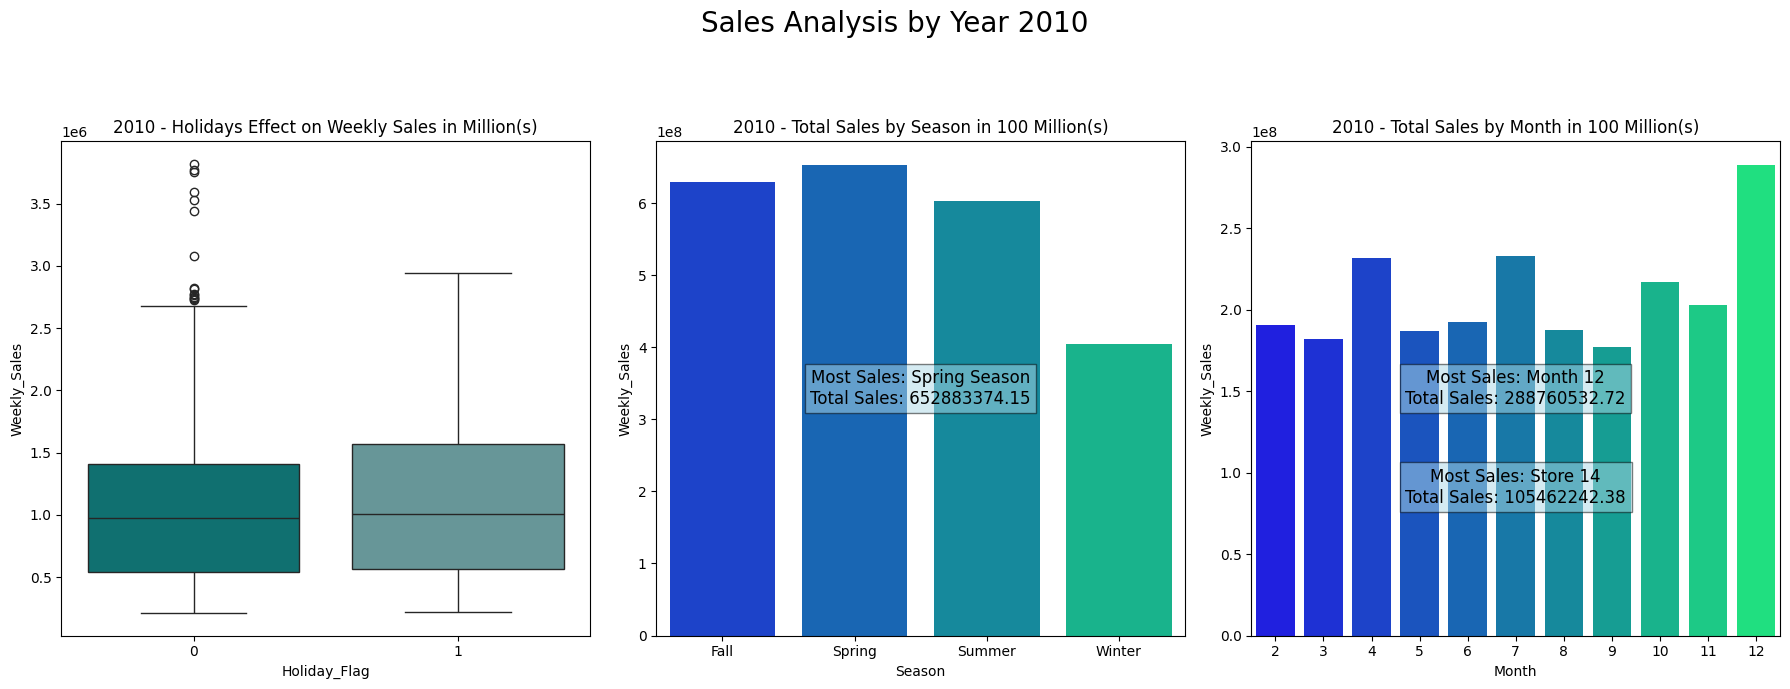

Year 2010 Analysis:
1. Holidays affect weekly sales, with the average sales during holidays being 1112358.88 compared to 1054879.56 on non-holidays.
2. The season with the most sales is Spring with total sales of 652883374.15.
3. The month with the most sales is 12 with total sales of 288760532.72.
4. The store with the most sales is Store 14 with total sales of 105462242.38.




In [ ]:
# Call the function to plot and analyze data for 2010
plot_and_analyze_yearly_data(2010)

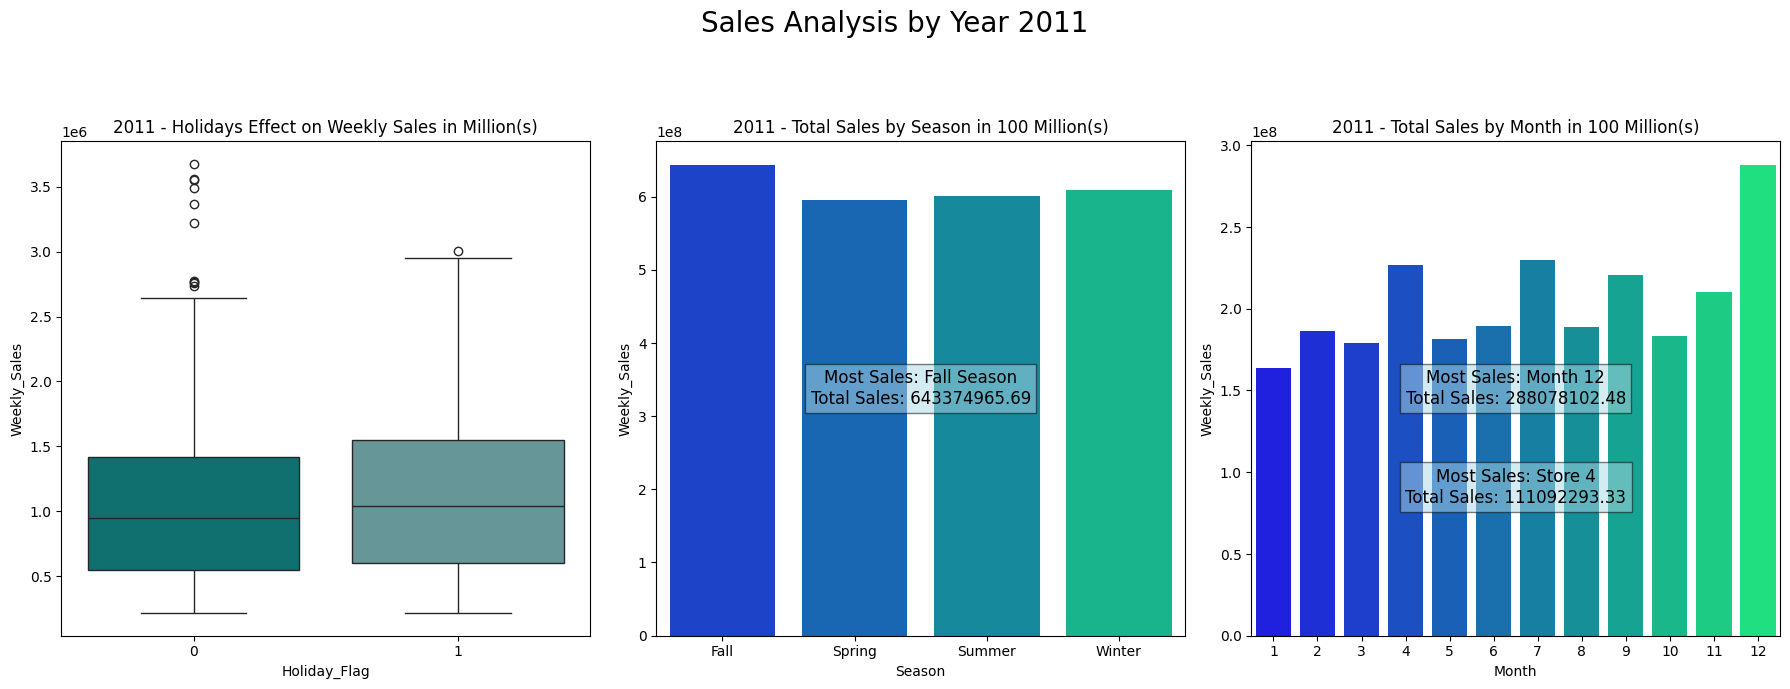

Year 2011 Analysis:
1. Holidays affect weekly sales, with the average sales during holidays being 1148530.48 compared to 1037715.06 on non-holidays.
2. The season with the most sales is Fall with total sales of 643374965.69.
3. The month with the most sales is 12 with total sales of 288078102.48.
4. The store with the most sales is Store 4 with total sales of 111092293.33.




In [ ]:
# Call the function to plot and analyze data for 2011
plot_and_analyze_yearly_data(2011)

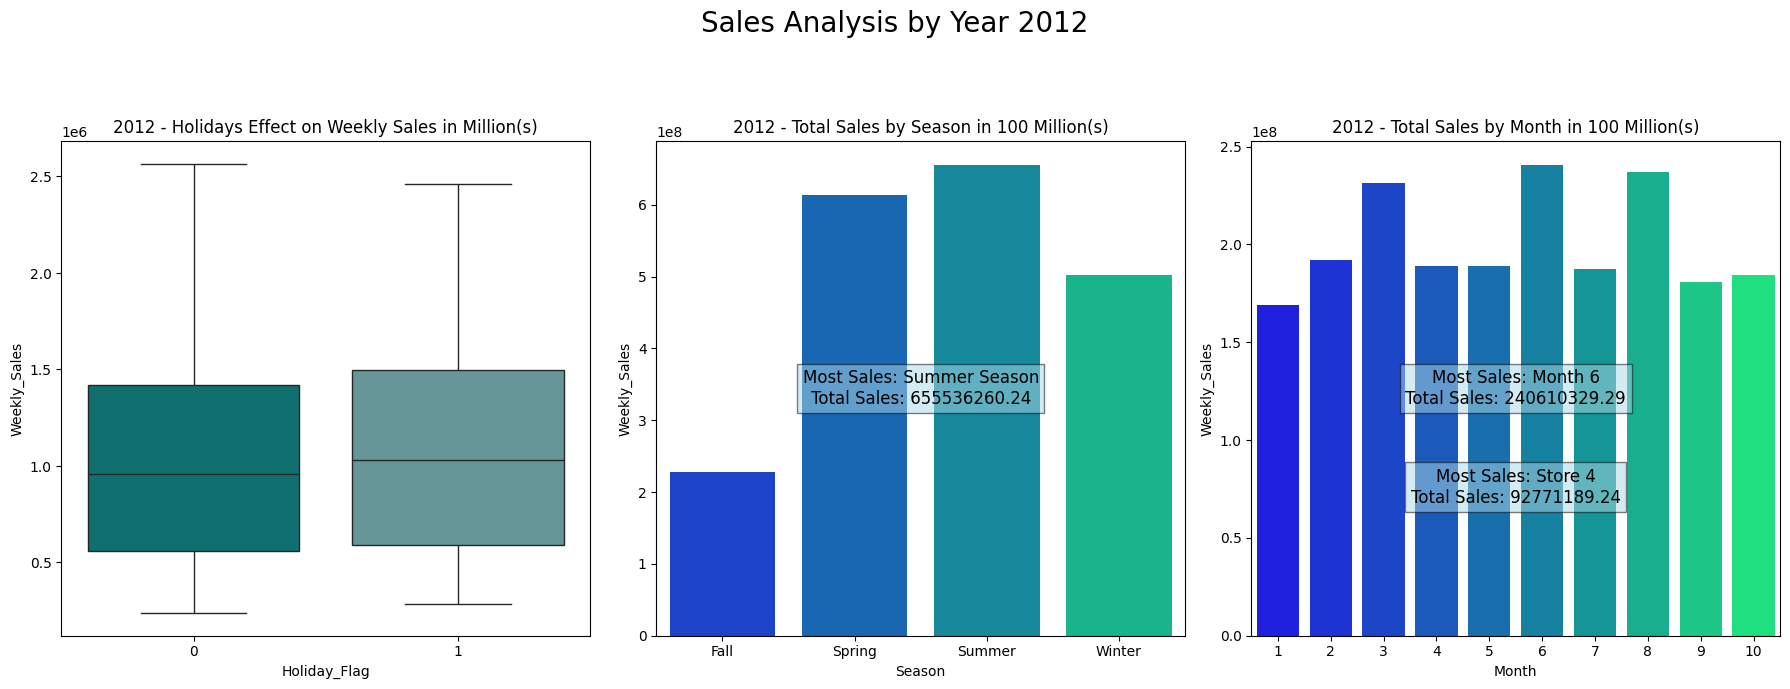

Year 2012 Analysis:
1. Holidays affect weekly sales, with the average sales during holidays being 1092660.75 compared to 1030782.33 on non-holidays.
2. The season with the most sales is Summer with total sales of 655536260.24.
3. The month with the most sales is 6 with total sales of 240610329.29.
4. The store with the most sales is Store 4 with total sales of 92771189.24.




In [ ]:
# Call the function to plot and analyze data for 2012
plot_and_analyze_yearly_data(2012)

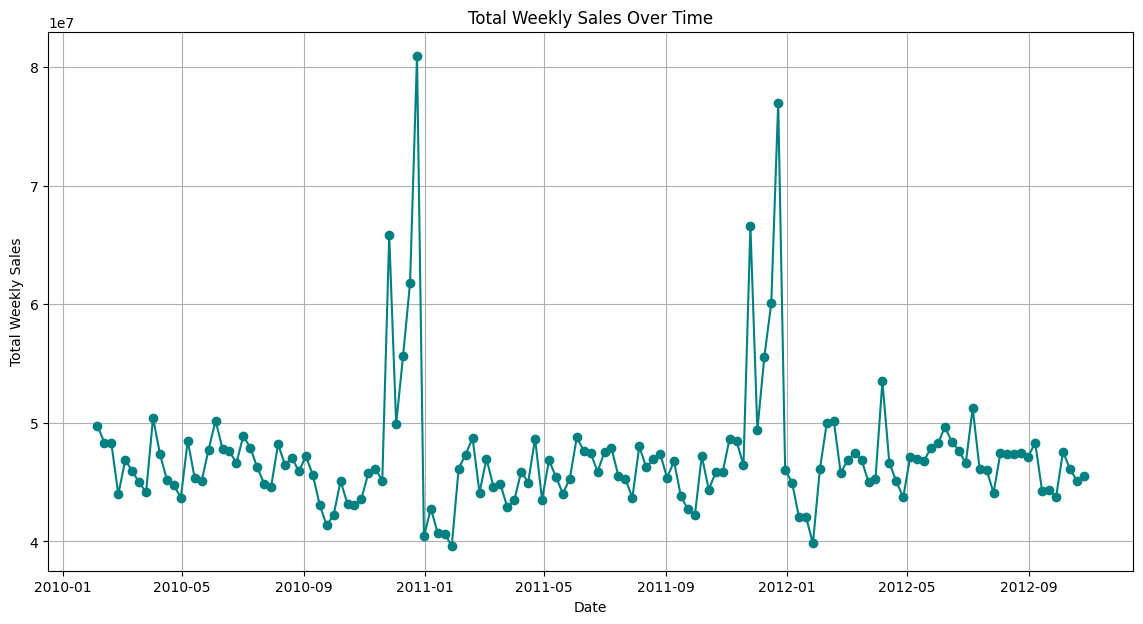

In [ ]:
# Plot the aggregated weekly sales
weekly_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(weekly_sales['Date'], weekly_sales['Weekly_Sales'], marker='o', color='#008080')
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.grid(True)
plt.show()

---
We can see this plots the aggregated weekly sales of the entire time frame of the dataset. The expected spikes are the November/December time frame.

---

In [ ]:
# Drop the Season and Weekday columns
df = df.drop(columns=['Season', 'Weekday', 'Date', 'Day'])

df

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,WeekOfYear
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,6
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,8
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,9
...,...,...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,2012,9,39
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,40
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,41
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,42


---
We only needed Season column for the sales analysis so we are deleting it. Weekday has been dropped as there is no insightful information from one day in the dataset which most likely is the day sales data is recorded on a weekly basis. Because we extracted from the Date column, we deleted it also.

---

####Scale Numerical Features

In [ ]:
# Scale numerical
scaler = StandardScaler()
numerical_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'WeekOfYear']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

---
Numerical features('Temperature', 'Fuel_Price', 'CPI', 'Unemployment') are scaled as a model is sensitive to the scale. It helps the model perform better and converge faster. We do not scale the target or categorical/binary features or the encoded features. Scale WeekOfYear, which is of type UInt32, to float as UIn32 can be problematic in limited precision or compatibilitly.

---

---
###Exploratory Data Analysis (EDA)

####Histograms

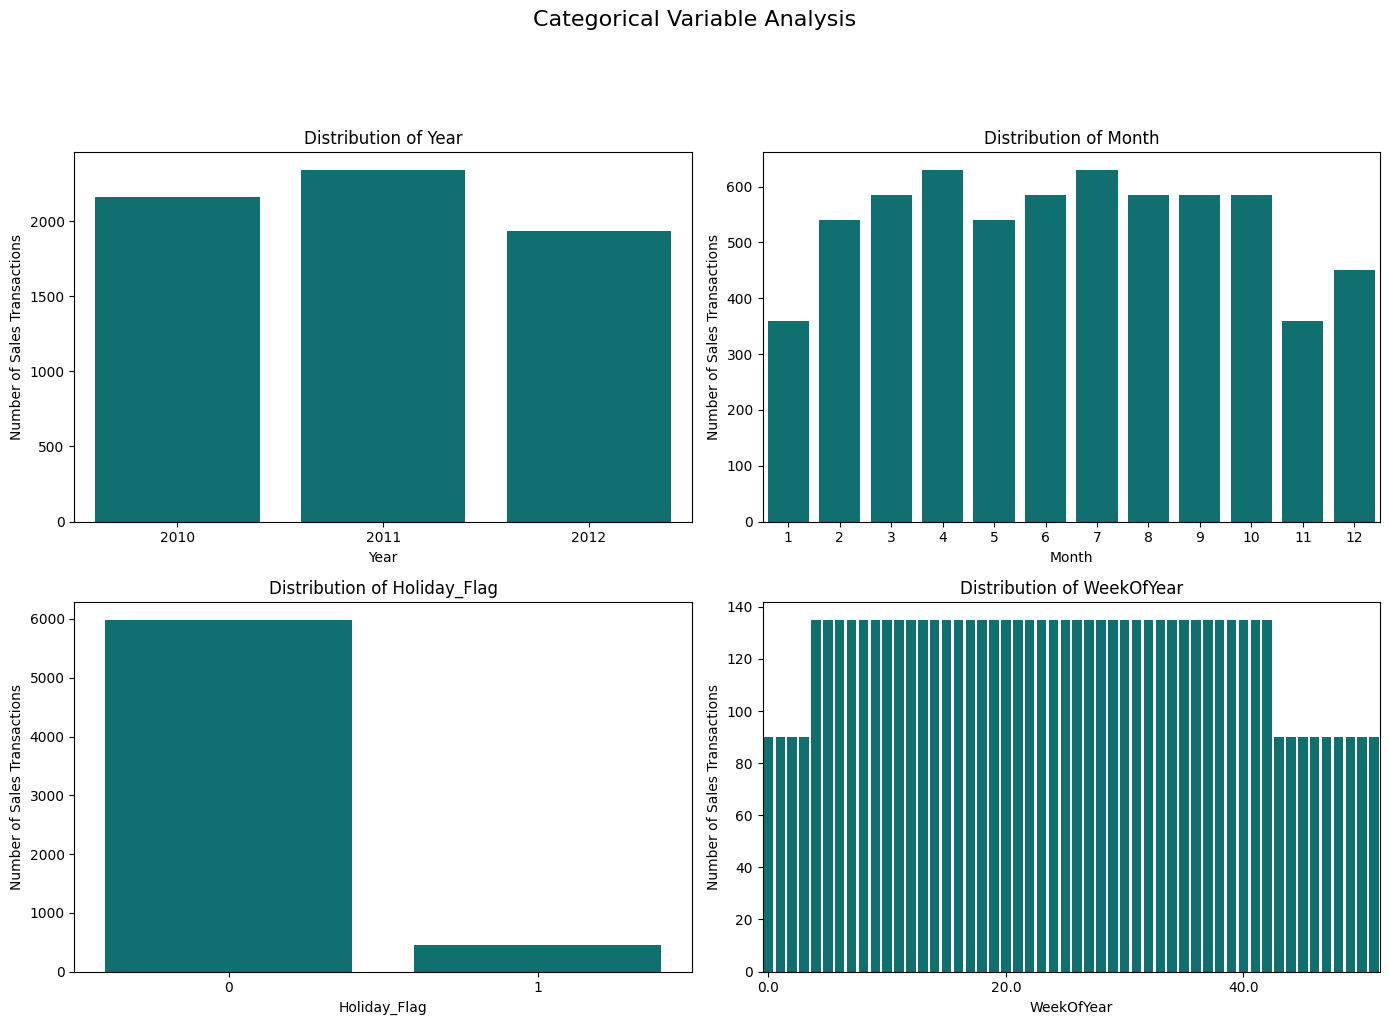

In [ ]:
# Define a function to format tick labels to four decimal places
def format_weekofyear_ticks(value, tick_number):
    return f'{value:.1f}'

# Distribution of Categorical Variables
plt.figure(figsize=(14, 10))

# Centered and Larger Title
plt.suptitle('Categorical Variable Analysis', fontsize=16, y=1.02)

# First Row: Distribution of Year and Month
plt.subplot(2, 2, 1)
sns.countplot(x='Year', data=df, color='teal')
plt.title('Distribution of Year')
plt.ylabel('Number of Sales Transactions')  # Label for Y-axis

plt.subplot(2, 2, 2)
sns.countplot(x='Month', data=df, color='teal')
plt.title('Distribution of Month')
plt.ylabel('Number of Sales Transactions')  # Label for Y-axis

# Second Row: Distribution of Holiday_Flag and WeekOfYear
plt.subplot(2, 2, 3)
sns.countplot(x='Holiday_Flag', data=df, color='teal')
plt.title('Distribution of Holiday_Flag')
plt.ylabel('Number of Sales Transactions')  # Label for Y-axis

plt.subplot(2, 2, 4)
sns.countplot(x='WeekOfYear', data=df, color='teal')
plt.title('Distribution of WeekOfYear')
plt.ylabel('Number of Sales Transactions')  # Label for Y-axis

# Adjust the x-axis for WeekOfYear to show every 20th week
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_weekofyear_ticks))
plt.xticks(range(0, 53, 20))  # Show every 20th week for WeekOfYear

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


---
2011 appears to have more data points and could be due to information gathered covers 2010-02-05 to 2012-11-01. April and July indicates higher peaks. As expected, there are more number of sales transactions on non holidays.

---

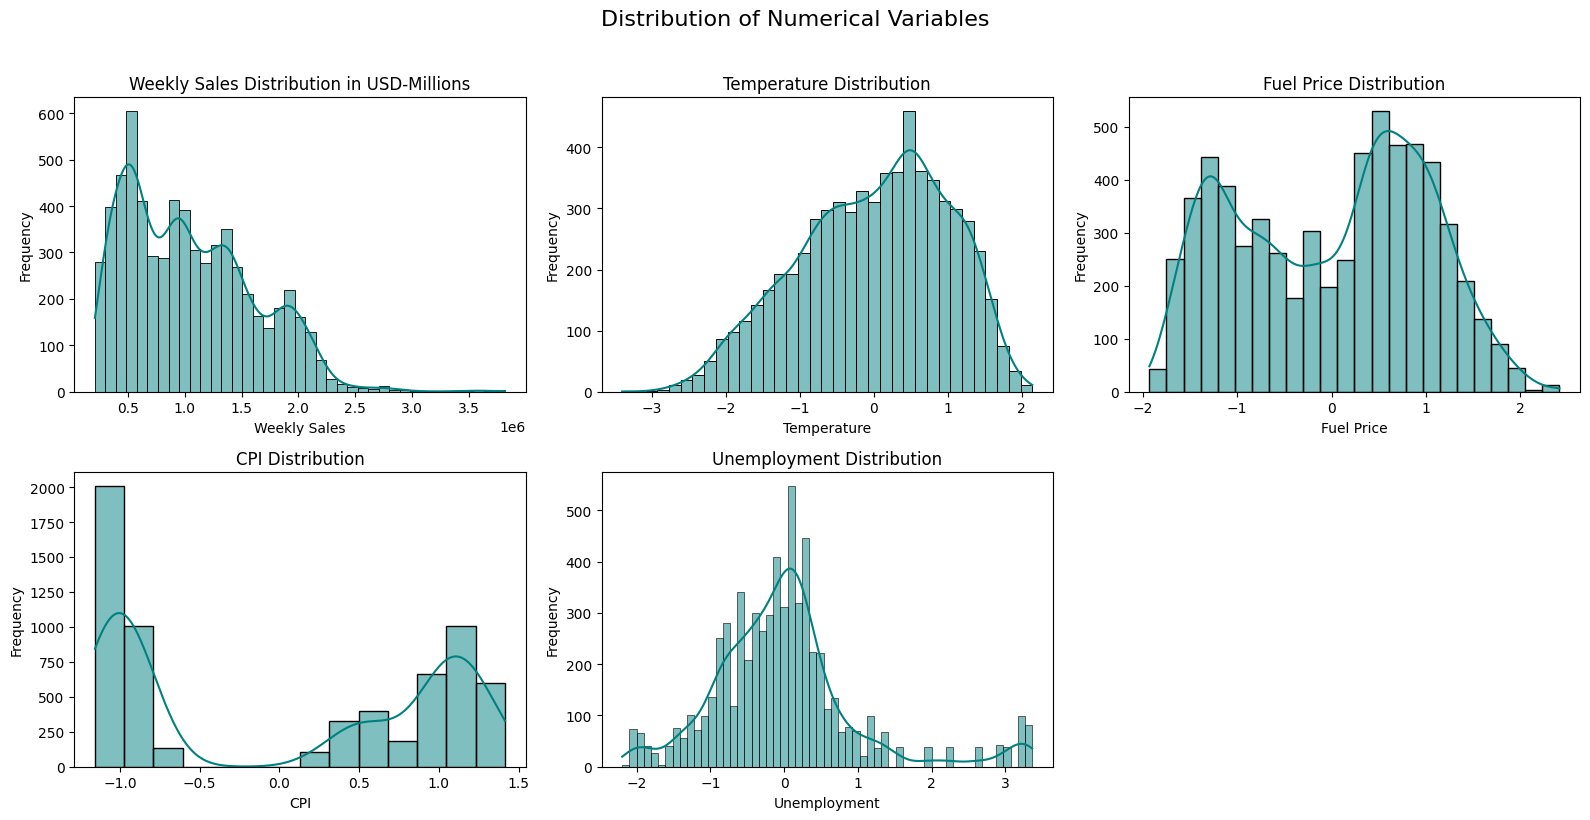

In [ ]:
# Distribution of Numerical Variables
plt.figure(figsize=(16, 8))

# Second Plots Title
plt.suptitle('Distribution of Numerical Variables', fontsize=16, y=1.02)

plt.subplot(2, 3, 1)
sns.histplot(df['Weekly_Sales'], kde=True, color='teal')
plt.title('Weekly Sales Distribution in USD-Millions')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
sns.histplot(df['Temperature'], kde=True, color='teal')
plt.title('Temperature Distribution')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

plt.subplot(2, 3, 3)
sns.histplot(df['Fuel_Price'], kde=True, color='teal')
plt.title('Fuel Price Distribution')
plt.xlabel('Fuel Price')
plt.ylabel('Frequency')

plt.subplot(2, 3, 4)
sns.histplot(df['CPI'], kde=True, color='teal')
plt.title('CPI Distribution')
plt.xlabel('CPI')
plt.ylabel('Frequency')

plt.subplot(2, 3, 5)
sns.histplot(df['Unemployment'], kde=True, color='teal')
plt.title('Unemployment Distribution')
plt.xlabel('Unemployment')
plt.ylabel('Frequency')

plt.tight_layout()

plt.show()


---
The features have been scaled, with the exception of our target Weekly_Sales, and should be distributed around a mean of 0 with a standard deviation of 1. Thus, these histograms are going to range typically from -3 to 3 and can be interpreted as follows:
- 0: Mean of the original data
- 1: 1 standard deviation above the mean
- -1: 1 standard deviation below the mean
- 2: 2 standard deviations above the mean
- -2: 2 standard deviations below the mean

Temperature
- with a slight left tail suggests some lower temperature values that are less frequent but still present.

Fuel Price
- has two price ranges with ~ 2 peaks positive and negative indicate price ranges with higher frequencies.

CPI
- has a flat distribution in the middle indicating a relatively  uniform distribution of values within the range of ~ -0.8 to 0.2.

Unemployment
- with a peak at 0 indicates that some records have low or no unemployment. With a few flat distributions and a slight right tail then a peak suggests some records with higher unemployment rate.

Weekly Sales
- Peak around 0.5 million USD with a right tail suggesting occasional high sales figures (special events or promotions or outliers).

---

####Correlation Matrix

Correlation Summaries:
Weekly_Sales and Store: There is a moderate correlation (-0.3353).
Year and Fuel_Price: There is a high correlation (0.7795).
Unemployment and CPI: There is a moderate correlation (-0.3020).
WeekOfYear and Month: There is a high correlation (0.9960).


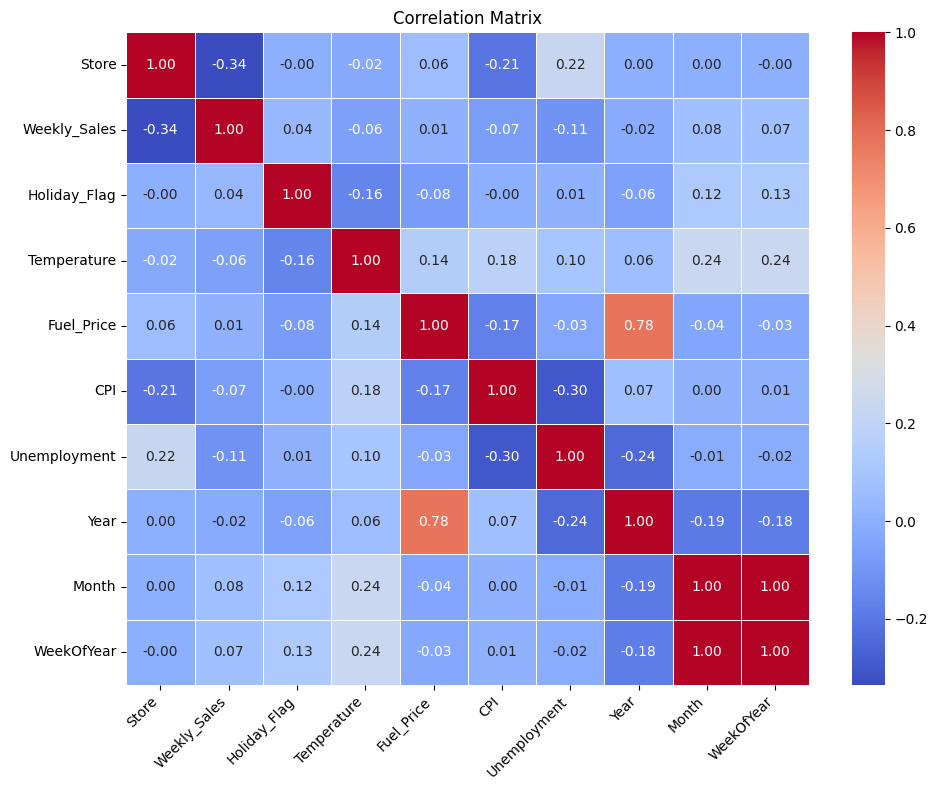

In [ ]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Define thresholds for interpreting correlations
moderate_corr_threshold = 0.3
high_corr_threshold = 0.6

# Function to summarize correlations
def summarize_correlations(corr_matrix):
    print("Correlation Summaries:")
    visited_pairs = set()  # To keep track of visited pairs
    for i, col in enumerate(corr_matrix.columns):
        for j, row in enumerate(corr_matrix.index):
            if i != j:  # Exclude self-correlation (diagonal elements)
                pair = tuple(sorted([row, col]))  # Sort pair to avoid duplicate output
                if pair not in visited_pairs:
                    visited_pairs.add(pair)
                    correlation = corr_matrix.loc[row, col]  # Access correlation value
                    if abs(correlation) >= high_corr_threshold:
                        print(f"{row} and {col}: There is a high correlation ({correlation:.4f}).")
                    elif abs(correlation) >= moderate_corr_threshold:
                        print(f"{row} and {col}: There is a moderate correlation ({correlation:.4f}).")

# Print correlation summaries
summarize_correlations(corr_matrix)

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---
High correlation:
- Year and Fuel_Price: There is a high correlation (0.7795)
 - There is a strong positive correlation between Year and Fuel_Price. This indicates that, over the years, fuel prices have tended to increase. This is expected as fuel prices generally rise over time due to inflation and other economic factors.
- WeekOfYear and Month: There is a high correlation (0.9960)
  - There is an extremely strong positive correlation between WeekOfYear and Month. This is likely due to the fact that both variables are time-related; WeekOfYear and Month are highly related because each month has a specific range of weeks. For instance, Week 1 of a month will always correlate strongly with the respective month.


Moderate correlation:
- Weekly_Sales and Store: There is a moderate correlation (-0.3353)
 - This suggests that, as the store number increases, the weekly sales tend to decrease, although the relationship is not very strong.
- Unemployment and CPI: There is a moderate correlation (-0.3020)
  - There is a moderate negative correlation between Unemployment and CPI (Consumer Price Index). This suggests that higher unemployment is somewhat associated with lower CPI, which could imply that periods of higher unemployment are associated with lower consumer prices, although the relationship is not very strong.

---



####Variance for Numerical Columns

In [ ]:
# List of numerical columns
numerical_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

# Calculate variance for numerical columns
variances = df[numerical_cols].var()

# Print variance for each numerical feature
print("Variances of Numerical Features:")
print(variances)

Variances of Numerical Features:
Temperature     1.000155
Fuel_Price      1.000155
CPI             1.000155
Unemployment    1.000155
dtype: float64


---
Variance is ~1.000155 for all . This indicates that the spread of values for these features is quite similar. Features have been standardized correctly as values are around 1.

---

---
###Feature Selection

In [ ]:
print(df.columns.tolist())


['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'WeekOfYear']


In [ ]:
# Define features and target
features = ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'WeekOfYear']
target = 'Weekly_Sales'

X = df[features]
y = df[target]

#####SelectKBest

In [ ]:
# Apply SelectKBest
k = 5  # Adjust as needed
selector = SelectKBest(score_func=f_regression, k=k)
selector.fit(X, y)

# Get selected features
top_feature_indices = selector.get_support(indices=True)
top_features = X.columns[top_feature_indices]

print("Top features from SelectKBest:")
print(top_features)


Top features from SelectKBest:
Index(['Store', 'CPI', 'Unemployment', 'Month', 'WeekOfYear'], dtype='object')


---
SelectKBest is one way to identify and select the most relevant features for improving model performance and reducing complexity.

---

####Save cleaned features to .csv

In [ ]:
# Get the selected features DataFrame
X_selected = X[top_features]  # X contains the features, and top_features are the selected ones

# Add the target variable to the DataFrame
data_to_save = X_selected.copy()  # Copy the DataFrame with selected features
data_to_save['Weekly_Sales'] = y.values  # Add the target variable

# Save the DataFrame to a CSV file
data_to_save.to_csv('/content/Walmart_cleaned.csv', index=False)
print("Selected features and target data saved to /content/Walmart_cleaned.csv")

Selected features and target data saved to /content/Walmart_cleaned.csv


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


In [ ]:
# 80-20 Split
X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(X_selected, y, test_size=0.2, random_state=42)
print("80-20 Split:")
print(f"X_train_80 shape: {X_train_80.shape}")
print(f"X_test_80 shape: {X_test_80.shape}")
print(f"y_train_80 shape: {y_train_80.shape}")
print(f"y_test_80 shape: {y_test_80.shape}")
print()

# 70-30 Split
X_train_70, X_test_70, y_train_70, y_test_70 = train_test_split(X_selected, y, test_size=0.3, random_state=42)
print("70-30 Split:")
print(f"X_train_70 shape: {X_train_70.shape}")
print(f"X_test_70 shape: {X_test_70.shape}")
print(f"y_train_70 shape: {y_train_70.shape}")
print(f"y_test_70 shape: {y_test_70.shape}")



80-20 Split:
X_train_80 shape: (5148, 5)
X_test_80 shape: (1287, 5)
y_train_80 shape: (5148,)
y_test_80 shape: (1287,)

70-30 Split:
X_train_70 shape: (4504, 5)
X_test_70 shape: (1931, 5)
y_train_70 shape: (4504,)
y_test_70 shape: (1931,)


---
The data is correctly divided according to the specified splits:
- 80:20 split
  - Training 5148 samples
  - Testing  1287 samples

- 70:30 spit
  - Training 4504 samples
  - Testing  1931 samples

---

---
##Model Selection

In [ ]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor()
}


---
Linear Regression is used as a baseline model because it’s simple and interpretable, making it a good starting point for regression tasks.

Random Forest Regressor and Gradient Boosting Regressor are used because they handle non-linearity and interactions between features well, often providing improved performance over linear models, especially on complex datas.

---

####Train Models

In [ ]:
# Train models on 80-20 split data
trained_models_80_20 = {}
for model_name, model in models.items():
    model.fit(X_train_80, y_train_80)
    trained_models_80_20[model_name] = model

print("Models trained on 80-20 split data.")

# Train models on 70-30 split data
trained_models_70_30 = {}
for model_name, model in models.items():
    model.fit(X_train_70, y_train_70)
    trained_models_70_30[model_name] = model

print("Models trained on 70-30 split data.")


Models trained on 80-20 split data.
Models trained on 70-30 split data.


###Evaluate Models

In [ ]:
# Function to compute and print metrics for regression
def print_regression_metrics(model_name, X_train, y_train, X_test, y_test):
    # Predict and calculate metrics
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Train metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)
    train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100  # MAPE as percentage

    # Test metrics
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100  # MAPE as percentage

    # Print results
    print(f"{model_name}:")
    print(f"Train - MAE: {train_mae:.4f}, MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}, MAPE: {train_mape:.2f}%")
    print(f"Test - MAE: {test_mae:.4f}, MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}, MAPE: {test_mape:.2f}%")
    print()

# Evaluate models with 80-20 split
print("Evaluating trained models with 80-20 split:")
for model_name, model in trained_models_80_20.items():
    print_regression_metrics(model_name, X_train_80, y_train_80, X_test_80, y_test_80)

# Evaluate models with 70-30 split
print("Evaluating trained models with 70-30 split:")
for model_name, model in trained_models_70_30.items():
    print_regression_metrics(model_name, X_train_70, y_train_70, X_test_70, y_test_70)


Evaluating trained models with 80-20 split:
Linear Regression:
Train - MAE: 428491.3055, MSE: 271695443728.7467, RMSE: 521244.1306, R²: 0.1443, MAPE: 60.72%
Test - MAE: 432171.4767, MSE: 274333180937.5306, RMSE: 523768.2512, R²: 0.1484, MAPE: 62.35%

Random Forest Regressor:
Train - MAE: 26053.8621, MSE: 3093172457.4931, RMSE: 55616.2967, R²: 0.9903, MAPE: 2.43%
Test - MAE: 60919.6118, MSE: 13233470853.0531, RMSE: 115036.8239, R²: 0.9589, MAPE: 5.67%

Gradient Boosting Regressor:
Train - MAE: 126438.0108, MSE: 29080400773.6192, RMSE: 170529.7651, R²: 0.9084, MAPE: 15.95%
Test - MAE: 127884.7107, MSE: 29963965969.6918, RMSE: 173101.0282, R²: 0.9070, MAPE: 16.29%

Evaluating trained models with 70-30 split:
Linear Regression:
Train - MAE: 428909.8387, MSE: 272461217398.5963, RMSE: 521978.1771, R²: 0.1427, MAPE: 60.95%
Test - MAE: 429967.9013, MSE: 271667335587.2150, RMSE: 521217.1674, R²: 0.1503, MAPE: 61.28%

Random Forest Regressor:
Train - MAE: 21149.5405, MSE: 1573263542.0633, RMSE: 

| Split | Model                       | Train MAE      | Train MSE              | Train RMSE     | Train R²   | Train MAPE | Test MAE      | Test MSE             | Test RMSE    | Test R²   | Test MAPE | Interpretation                                                                             |
|-------|-----------------------------|----------------|------------------------|----------------|------------|------------|---------------|-----------------------|--------------|-----------|-----------|------------------------------------------------------------------------------------------|
| 80-20 | Linear Regression           | 428,491.31     | 271,695,443,728.75     | 521,244.13     | 0.1443     | 60.72%     | 432,171.48    | 274,333,180,937.53    | 523,768.25   | 0.1484    | 62.35%    | Poor performance; low R^2; high MAE/MAPE-weak fit                         |
|       | Random Forest      | 26,127.37      | 3,033,916,755.92       | 55,081.00      | 0.9904     | 2.43%      | 60,601.48     | 12,826,651,957.71     | 113,254.81   | 0.9602    | 5.63%     | Excellent; low MAE/MSE on train; strong w/high R^2 on test  |
|       | Gradient Boosting | 126,438.01     | 29,080,400,773.62      | 170,529.77     | 0.9084     | 15.95%     | 127,884.71    | 29,974,395,605.63    | 173,131.15   | 0.9070    | 16.29%    | Good fit; moderate MAE/MAPE; R^2 slightly lower than RF          |
| 70-30 | Linear Regression           | 428,909.84     | 272,461,217,398.60     | 521,978.18     | 0.1427     | 60.95%     | 429,967.90    | 271,667,335,587.22    | 521,217.17   | 0.1503    | 61.28%    | Consistent w/80-20 split; poor performance/ high errors              |
|       | Random Forest     | 21,301.63      | 1,597,921,390.62       | 39,974.01      | 0.9950     | 2.01%      | 60,360.06     | 12,910,132,877.09    | 113,622.77   | 0.9596    | 5.55%     | Excellent; low MAE/MSE on train/tes; high R^2 - best fit.   |
|       | Gradient Boosting | 126,046.74     | 28,818,319,826.85      | 169,759.59     | 0.9093     | 15.98%     | 128,314.85    | 30,287,539,009.26    | 174,033.15   | 0.9053    | 16.10%    | Good; like 80-20 split; moderate MAE/MAPE; lower R^2            |



---

*Linear Regression:*

- Consistently poor performance with low R^2 and high error metrics. The model is not fitting the data well.

*Random Forest Regressor:*

- Shows excellent performance with very low MAE and MSE values for both training and testing, indicating it is the best model among the three.

*Gradient Boosting Regressor:*

- Performs reasonably well, but with higher MAE and MAPE compared to Random Forest. R^2 values are slightly lower, suggesting it is less effective than Random Forest.

*Conclusion:*

- As we are looking for high R^2 (to explain large portion of variance in the target value, and closer to 1 suggets a better fit) and a low MAPE (lower reflects better accuracy in prediction), we will proceed to tune only the best two: Random Forest Regressor and Gradient Boosting Regressor.

---

##Hyperparameter Tuning

####Best Parameters

We look for best parameters to optimize model performance, ensuring that the model generalizes well to unseen data by balancing bias and variance, and to improve the accuracy and reliability of predictions. We will use 80/20 and 70/30 best parameters to evaluate how well a model generalizes to new and unseen data.

#####RandomForestClassifier

In [ ]:
# Parameter grid for RandomForestRegressor
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],
    'max_features': ['sqrt'],
}

# Initialize model
rf_model = RandomForestRegressor(random_state=42)

# Create GridSearchCV instance for 80-20 split
grid_search_rf_80_20 = GridSearchCV(rf_model, param_grid_rf, cv=5, n_jobs=-1, error_score='raise')

# Fit model to perform search using 80-20 split data
grid_search_rf_80_20.fit(X_train_80, y_train_80)

# Get best hyperparameters from search
best_rf_params_80_20 = grid_search_rf_80_20.best_params_

# Print the best hyperparameters for 80-20 split
print("\nBest Hyperparameters for RandomForestRegressor with 80-20 split:")
for param, value in best_rf_params_80_20.items():
    print(f"{param}: {value}")


Best Hyperparameters for RandomForestRegressor with 80-20 split:
bootstrap: False
max_depth: 20
max_features: sqrt
min_samples_leaf: 1
min_samples_split: 5
n_estimators: 100


In [ ]:
# Parameter grid for RandomForestRegressor
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],
    'max_features': ['sqrt'],
}

# Initialize model
rf_model = RandomForestRegressor(random_state=42)

# Create GridSearchCV instance for 70-30 split
grid_search_rf_70_30 = GridSearchCV(rf_model, param_grid_rf, cv=5, n_jobs=-1, error_score='raise')

# Fit model to perform search using 70-30 split data
grid_search_rf_70_30.fit(X_train_70, y_train_70)

# Get best hyperparameters from search
best_rf_params_70_30 = grid_search_rf_70_30.best_params_

# Print the best hyperparameters for 70-30 split
print("\nBest Hyperparameters for RandomForestRegressor with 70-30 split:")
for param, value in best_rf_params_70_30.items():
    print(f"{param}: {value}")



Best Hyperparameters for RandomForestRegressor with 70-30 split:
bootstrap: False
max_depth: 20
max_features: sqrt
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 100


#####Gradient Boosting

In [ ]:
# Parameter grid for GradientBoostingRegressor
param_grid_gb = {
    'n_estimators': [100, 200], # Number of boosting stages to be run
    'learning_rate': [0.01, 0.1], # Step size for each iteration
    'max_depth': [3, 5], # Maximum depth of the individual trees
    'min_samples_split': [2, 5], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2], # Minimum number of samples required to be at a leaf node
}

# Initialize model
gb_model = GradientBoostingRegressor(random_state=42)

# Create GridSearchCV instance for 80-20 split
grid_search_gb_80_20 = GridSearchCV(gb_model, param_grid_gb, cv=5, n_jobs=-1, error_score='raise')

# Fit model to perform search using 80-20 split data
grid_search_gb_80_20.fit(X_train_80, y_train_80)

# Get best hyperparameters from search
best_gb_params_80_20 = grid_search_gb_80_20.best_params_

# Print the best hyperparameters for 80-20 split
print("\nBest Hyperparameters for GradientBoostingRegressor with 80-20 split:")
for param, value in best_gb_params_80_20.items():
    print(f"{param}: {value}")


Best Hyperparameters for GradientBoostingRegressor with 80-20 split:
learning_rate: 0.1
max_depth: 5
min_samples_leaf: 1
min_samples_split: 5
n_estimators: 200


In [ ]:
# Parameter grid for GradientBoostingRegressor
param_grid_gb = {
    'n_estimators': [100, 200], # Number of boosting stages to be run
    'learning_rate': [0.01, 0.1], # Step size for each iteration
    'max_depth': [3, 5], # Maximum depth of the individual trees
    'min_samples_split': [2, 5], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2], # Minimum number of samples required to be at a leaf node
}

# Initialize model
gb_model = GradientBoostingRegressor(random_state=42)

# Create GridSearchCV instance for 70-30 split
grid_search_gb_70_30 = GridSearchCV(gb_model, param_grid_gb, cv=5, n_jobs=-1, error_score='raise')

# Fit model to perform search using 80-20 split data
grid_search_gb_70_30.fit(X_train_70, y_train_70)

# Get best hyperparameters from search
best_gb_params_70_30 = grid_search_gb_70_30.best_params_

# Print the best hyperparameters for 70-30 split
print("\nBest Hyperparameters for GradientBoostingRegressor with 80-20 split:")
for param, value in best_gb_params_70_30.items():
    print(f"{param}: {value}")




Best Hyperparameters for GradientBoostingRegressor with 80-20 split:
learning_rate: 0.1
max_depth: 5
min_samples_leaf: 2
min_samples_split: 5
n_estimators: 200


####Reinitialize Models

In [ ]:
# Reinitialize models with best hyperparameters for 80-20 split
rf_model_80_20 = RandomForestRegressor(random_state=42, **best_rf_params_80_20)
gb_model_80_20 = GradientBoostingRegressor(random_state=42, **best_gb_params_80_20)

# Fit the reinitialized models on the 80-20 split data
rf_model_80_20.fit(X_train_80, y_train_80)
gb_model_80_20.fit(X_train_80, y_train_80)

print("Models fitted with best hyperparameters for 80-20 split.")

# Reinitialize models with best hyperparameters for 70-30 split
rf_model_70_30 = RandomForestRegressor(random_state=42, **best_rf_params_70_30)
gb_model_70_30 = GradientBoostingRegressor(random_state=42, **best_gb_params_70_30)

# Fit the reinitialized models on the 70-30 split data
rf_model_70_30.fit(X_train_70, y_train_70)
gb_model_70_30.fit(X_train_70, y_train_70)

print("Models fitted with best hyperparameters for 70-30 split.")



Models fitted with best hyperparameters for 80-20 split.
Models fitted with best hyperparameters for 70-30 split.


---
Reinitializing with the best parameters before evaluation ensures that the model is tested with the optimal settings, providing an accurate assessment of its performance.

---

---
##Evaluate

###Define the Evaluation Function

In [ ]:
# Define the evaluation function
def evaluate_and_print(model, X_train, y_train, X_test, y_test, model_name):
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Compute MAPE
    def compute_mape(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        nonzero_elements = y_true != 0
        if np.any(nonzero_elements):
            return np.mean(np.abs((y_true[nonzero_elements] - y_pred[nonzero_elements]) / y_true[nonzero_elements])) * 100
        else:
            return np.nan  # Return NaN if there are no non-zero elements

    # Compute metrics
    metrics = {
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Train MSE': mean_squared_error(y_train, y_train_pred),
        'Train RMSE': mean_squared_error(y_train, y_train_pred, squared=False),
        'Train R²': r2_score(y_train, y_train_pred),
        'Train MAPE': compute_mape(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Test MSE': mean_squared_error(y_test, y_test_pred),
        'Test RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
        'Test R²': r2_score(y_test, y_test_pred),
        'Test MAPE': compute_mape(y_test, y_test_pred)
    }

    return metrics


---
This has the calculation for MAPE within it. This function is called a few times during model evaluation(s).

---

###Evaluation

In [ ]:
# Evaluate models on 80-20 split
print("Evaluation on 80-20 Split")
print()

# Print metrics for Random Forest Regressor 80-20
metrics_rf_80_20 = evaluate_and_print(rf_model_80_20, X_train_80, y_train_80, X_test_80, y_test_80, "Random Forest Regressor 80-20")
print(f"Random Forest Regressor 80-20:")
print(f"Train - MAE: {metrics_rf_80_20['Train MAE']:.4f}, MSE: {metrics_rf_80_20['Train MSE']:.4f}, RMSE: {metrics_rf_80_20['Train RMSE']:.4f}, R²: {metrics_rf_80_20['Train R²']:.4f}, MAPE: {metrics_rf_80_20['Train MAPE']:.2f}%")
print(f"Test - MAE: {metrics_rf_80_20['Test MAE']:.4f}, MSE: {metrics_rf_80_20['Test MSE']:.4f}, RMSE: {metrics_rf_80_20['Test RMSE']:.4f}, R²: {metrics_rf_80_20['Test R²']:.4f}, MAPE: {metrics_rf_80_20['Test MAPE']:.2f}%")
print()

# Print metrics for GradientBoosting 80-20
metrics_gb_80_20 = evaluate_and_print(gb_model_80_20, X_train_80, y_train_80, X_test_80, y_test_80, "Gradient Boosting 80-20")
print(f"Gradient Boosting 80-20:")
print(f"Train - MAE: {metrics_gb_80_20['Train MAE']:.4f}, MSE: {metrics_gb_80_20['Train MSE']:.4f}, RMSE: {metrics_gb_80_20['Train RMSE']:.4f}, R²: {metrics_gb_80_20['Train R²']:.4f}, MAPE: {metrics_gb_80_20['Train MAPE']:.2f}%")
print(f"Test - MAE: {metrics_gb_80_20['Test MAE']:.4f}, MSE: {metrics_gb_80_20['Test MSE']:.4f}, RMSE: {metrics_gb_80_20['Test RMSE']:.4f}, R²: {metrics_gb_80_20['Test R²']:.4f}, MAPE: {metrics_gb_80_20['Test MAPE']:.2f}%")
print()

# Evaluate models on 70-30 split
print("Evaluation on 70-30 Split")

# Print metrics for Random Forest Regressor 70-30
metrics_rf_70_30 = evaluate_and_print(rf_model_70_30, X_train_70, y_train_70, X_test_70, y_test_70, "Random Forest Regressor 70-30")
print(f"Random Forest Regressor 70-30:")
print(f"Train - MAE: {metrics_rf_70_30['Train MAE']:.4f}, MSE: {metrics_rf_70_30['Train MSE']:.4f}, RMSE: {metrics_rf_70_30['Train RMSE']:.4f}, R²: {metrics_rf_70_30['Train R²']:.4f}, MAPE: {metrics_rf_70_30['Train MAPE']:.2f}%")
print(f"Test - MAE: {metrics_rf_70_30['Test MAE']:.4f}, MSE: {metrics_rf_70_30['Test MSE']:.4f}, RMSE: {metrics_rf_70_30['Test RMSE']:.4f}, R²: {metrics_rf_70_30['Test R²']:.4f}, MAPE: {metrics_rf_70_30['Test MAPE']:.2f}%")
print()

# Print metrics for GradientBoosting 70-30
metrics_gb_70_30 = evaluate_and_print(gb_model_70_30, X_train_70, y_train_70, X_test_70, y_test_70, "Gradient Boosting 70-30")
print(f"Gradient Boosting 70-30:")
print(f"Train - MAE: {metrics_gb_70_30['Train MAE']:.4f}, MSE: {metrics_gb_70_30['Train MSE']:.4f}, RMSE: {metrics_gb_70_30['Train RMSE']:.4f}, R²: {metrics_gb_70_30['Train R²']:.4f}, MAPE: {metrics_gb_70_30['Train MAPE']:.2f}%")
print(f"Test - MAE: {metrics_gb_70_30['Test MAE']:.4f}, MSE: {metrics_gb_70_30['Test MSE']:.4f}, RMSE: {metrics_gb_70_30['Test RMSE']:.4f}, R²: {metrics_gb_70_30['Test R²']:.4f}, MAPE: {metrics_gb_70_30['Test MAPE']:.2f}%")

Evaluation on 80-20 Split

Random Forest Regressor 80-20:
Train - MAE: 25026.7465, MSE: 1892766317.0239, RMSE: 43505.9343, R²: 0.9940, MAPE: 2.51%
Test - MAE: 65329.3736, MSE: 13653351712.4189, RMSE: 116847.5576, R²: 0.9576, MAPE: 6.70%

Gradient Boosting 80-20:
Train - MAE: 37599.0041, MSE: 2954035372.8733, RMSE: 54351.0384, R²: 0.9907, MAPE: 4.15%
Test - MAE: 52742.4127, MSE: 7469430987.1345, RMSE: 86425.8699, R²: 0.9768, MAPE: 5.46%

Evaluation on 70-30 Split
Random Forest Regressor 70-30:
Train - MAE: 2704.8332, MSE: 39252033.1556, RMSE: 6265.1443, R²: 0.9999, MAPE: 0.27%
Test - MAE: 68586.3458, MSE: 14959224610.5631, RMSE: 122307.9090, R²: 0.9532, MAPE: 6.70%

Gradient Boosting 70-30:
Train - MAE: 37276.9539, MSE: 2922760792.1934, RMSE: 54062.5637, R²: 0.9908, MAPE: 4.18%
Test - MAE: 52977.0551, MSE: 7471705401.7043, RMSE: 86439.0271, R²: 0.9766, MAPE: 5.51%


Summary

---

| Split | Model                       | Train MAE   | Train MSE           | Train RMSE   | Train R²   | Train MAPE | Test MAE    | Test MSE           | Test RMSE   | Test R²   | Test MAPE | Interpretation                                                    |
|-------|-----------------------------|-------------|---------------------|--------------|------------|------------|-------------|--------------------|-------------|-----------|-----------|-------------------------------------------------------------------|
| 80-20 | Random Forest Regressor      | 25,026.75   | 1,892,766,317.02    | 43,505.93    | 0.9940     | 2.51%      | 65,329.37   | 13,653,351,712.42   | 116,847.56  | 0.9576    | 6.70%     | Excellent; high R^2; low errors; slight increase in test MAPE    |
|       | Gradient Boosting Regressor  | 37,599.00   | 2,954,035,372.87    | 54,351.04    | 0.9907     | 4.15%      | 52,742.41   | 7,469,430,987.13    | 86,425.87   | 0.9768    | 5.46%     | Strong; high R^2; low errors; better generalization              |
| 70-30 | Random Forest Regressor      | 2,704.83    | 39,252,033.16       | 6,265.14     | 0.9999     | 0.27%      | 68,586.35   | 14,959,224,610.56   | 122,307.91  | 0.9532    | 6.70%     | Exceptional training; good test; very low errors|
|       | Gradient Boosting Regressor  | 37,276.95   | 2,922,760,792.19    | 54,062.56    | 0.9908     | 4.18%      | 52,977.06   | 7,471,705,401.70    | 86,439.03   | 0.9766    | 5.51%     | Strong; consistent w/80-20; slightly higher MAPE  |


*Random Forest Regressor:*

- The 80/20 split has a slightly higher R^2 so it captures the variability in the data more effectively. The 80/20 split has lower MAE/RMSE suggesting better prediction accuracy.

*Gradient Boosting Regressor:*

- The 80/20 split has a slightly higher test R^2 suggesting better overall ability to capture variability in the data. This split also has lower test MAE/RMSE, suggesting better prediction accuracy.

*Conclusion*

- Gradient Boosting Regressor with the 80/20 split delivers superior performance in terms of accuracy and error metrics, which is crucial for predicting sales and other business metrics effectively.

- The model's lower MAE, RMSE, and MAPE suggests it will offer reliable predictions on new, unseen data, which is essential for forecasting and decision-making in a real-world scenario like Walmart's sales predictions.

- Gradient Boosting Regressor with the 80/20 split is recommended due to its combination of higher accuracy, better error metrics, and stronger overall performance for predicting.


####Save the model

In [ ]:
# Save the predictions to a CSV file
predictions_df.to_csv('gradient_boosting_predictions_80_20.csv', index=False)
print("Predictions saved as 'gradient_boosting_predictions_80_20.csv'.")
# Save predictions to a CSV file
predictions_df.to_csv('linear_regression_predictions_70_30.csv', index=False)

# Save the Gradient Boosting model
joblib.dump(gb_model_80_20, 'gradient_boosting_model_80_20.pkl')
print("Gradient Boosting model saved as 'gradient_boosting_model_80_20.pkl'.")

print("Predictions and model saved successfully.")

##Predict

In [ ]:
# Load cleaned prediction data
cleaned_prediction_data = pd.read_csv('Walmart_cleaned.csv')

# Display the first few rows of the dataframe to check the structure
print(cleaned_prediction_data.head())

# Display the columns to ensure they match your feature set
print(cleaned_prediction_data.columns)

   Store       CPI  Unemployment  Month  WeekOfYear  Weekly_Sales
0      1  1.004175      0.056964      2   -1.473530    1643690.90
1      1  1.007880      0.056964      2   -1.402749    1641957.44
2      1  1.009074      0.056964      2   -1.331968    1611968.17
3      1  1.009849      0.056964      2   -1.261187    1409727.59
4      1  1.010624      0.056964      3   -1.190406    1554806.68
Index(['Store', 'CPI', 'Unemployment', 'Month', 'WeekOfYear', 'Weekly_Sales'], dtype='object')


---
Load cleaned target and selected features we saved in Walmart_cleaned.csv.

---

In [ ]:
# Prepare feature columns for prediction
feature_columns = ['Store', 'CPI', 'Unemployment', 'Month', 'WeekOfYear']

# Extract features for prediction
X_predict = cleaned_prediction_data[feature_columns]

---
Prepare data for prediction.

---

In [ ]:
# Make predictions
cleaned_prediction_data['Predicted_Weekly_Sales'] = gb_model_80_20.predict(X_predict)

---
Make predictions using selected and trained model gb_model_80_20.

---

In [ ]:
# Inspect the first few rows to ensure predictions are added
print(cleaned_prediction_data[['Store', 'CPI', 'Unemployment', 'Month', 'WeekOfYear', 'Predicted_Weekly_Sales']].head())

   Store       CPI  Unemployment  Month  WeekOfYear  Predicted_Weekly_Sales
0      1  1.004175      0.056964      2   -1.473530            1.630513e+06
1      1  1.007880      0.056964      2   -1.402749            1.625653e+06
2      1  1.009074      0.056964      2   -1.331968            1.634658e+06
3      1  1.009849      0.056964      2   -1.261187            1.445775e+06
4      1  1.010624      0.056964      3   -1.190406            1.516238e+06


---
Inspect the dataframe.

---

In [ ]:
# Check if 'Weekly_Sales' exists in the dataframe for comparison
if 'Weekly_Sales' in cleaned_prediction_data.columns:
    # Compute evaluation metrics
    mae = mean_absolute_error(cleaned_prediction_data['Weekly_Sales'], cleaned_prediction_data['Predicted_Weekly_Sales'])
    mse = mean_squared_error(cleaned_prediction_data['Weekly_Sales'], cleaned_prediction_data['Predicted_Weekly_Sales'])
    rmse = np.sqrt(mse)
    r2 = r2_score(cleaned_prediction_data['Weekly_Sales'], cleaned_prediction_data['Predicted_Weekly_Sales'])

    # Print metrics
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
else:
    print("Actual values ('Weekly_Sales') not found in the dataframe.")


Mean Absolute Error: 40627.6858
Mean Squared Error: 3857114495.7256
Root Mean Squared Error: 62105.6720
R² Score: 0.9879


---

- MAE 40627.6858 - On average, the model's predictions are off by approximately $40,628. This provides a straightforward measure of prediction accuracy in the same units as the target variable (weekly sales).
- RMSE: 62,105.67 - provides the average prediction error in the same units as the target variable. It gives an idea of the magnitude of the errors, showing that on average, predictions are off by around 62,106 (USD).
- R^2: 0.9879 - This indicates that approximately 98.79% of the variability in weekly sales can be explained by the model. It suggests an excellent fit, meaning the model's predictions are very close to the actual values.
- Overall, the metrics indicate that the model performs very well, with low error and a high explanatory power.

---

In [ ]:
# Save the predictions along with actual values to a new CSV file
cleaned_prediction_data.to_csv('predictions_with_actuals.csv', index=False)

---
Saved new predictions to .csv.

---

In [ ]:
# Load the saved CSV file to verify
saved_data = pd.read_csv('predictions_with_actuals.csv')

# Display the first few rows of the saved data
print(saved_data.head())

# next tim try pd.set_option('display.float_format', '{:.2f}'.format)
#no scientific numbers.

   Store       CPI  Unemployment  Month  WeekOfYear  Weekly_Sales  \
0      1  1.004175      0.056964      2   -1.473530    1643690.90   
1      1  1.007880      0.056964      2   -1.402749    1641957.44   
2      1  1.009074      0.056964      2   -1.331968    1611968.17   
3      1  1.009849      0.056964      2   -1.261187    1409727.59   
4      1  1.010624      0.056964      3   -1.190406    1554806.68   

   Predicted_Weekly_Sales  
0            1.630513e+06  
1            1.625653e+06  
2            1.634658e+06  
3            1.445775e+06  
4            1.516238e+06  


---
Reload and read saved csv of new predictions.

Row 0, Store 1:
- Weekly_Sales            1,643,690.90
- Predicted_Weekly_Sales  1,630,513.00

Original data before scaling for Row 0, Store 1 is
- Weekly Sales
  - 1643690.90
- WeekOfYear
    - 5
- Month
  - 2

---




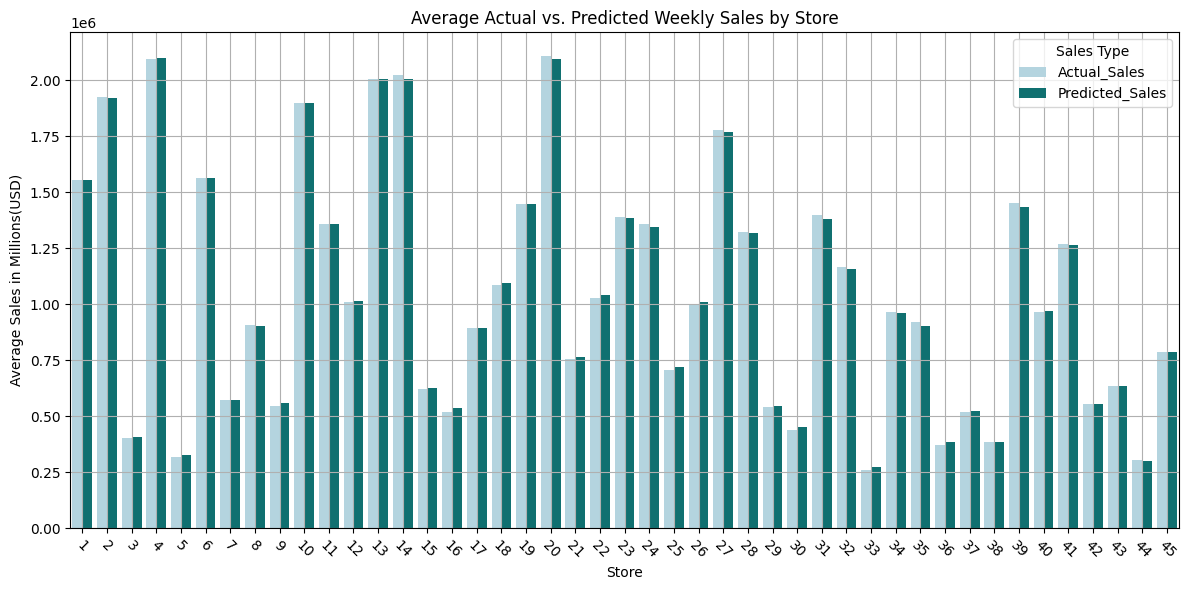

In [ ]:
# Aggregate data by store
store_agg = cleaned_prediction_data.groupby('Store').agg({
    'Weekly_Sales': 'mean',  # Actual Weekly Sales
    'Predicted_Weekly_Sales': 'mean'  # Predicted Weekly Sales
}).reset_index()

# Rename columns for clarity
store_agg.rename(columns={
    'Weekly_Sales': 'Actual_Sales',
    'Predicted_Weekly_Sales': 'Predicted_Sales'
}, inplace=True)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=store_agg.melt(id_vars='Store', var_name='Sales_Type', value_name='Sales'),
            x='Store', y='Sales', hue='Sales_Type',
            palette={'Actual_Sales': 'lightblue', 'Predicted_Sales': 'teal'})
plt.xlabel('Store')
plt.ylabel('Average Sales in Millions(USD)')
plt.title('Average Actual vs. Predicted Weekly Sales by Store')
plt.xticks(rotation=-45)  # Rotate x-axis labels at -45 degrees
plt.legend(title='Sales Type')
plt.grid(True)
plt.tight_layout()
plt.show()


---
##Summary of Findings

- **Dataset Overview:**
  - The dataset includes historical sales data for 45 Walmart stores across various regions from 2010-02-05 to 2012-11-01. It contains economic factors, holiday information, and promotional markdown events that may affect sales. The goal is to develop a model to improve sales and demand prediction accuracy, optimizing inventory management, staffing, and marketing strategies. In understanding the key factors that influence sales at Walmart stores, we may develop a model that accurately predicts future sales. This model can help Walmart optimize inventory management, staffing, and marketing strategies but at the same time interpretability and understanding feature impacts may be more critical.

- **Key Insights:**

  - **Sales Trends:**
    - **Seasonal Peaks:** Peak sales are initially observed in April to July. Upon further review, the absence of January 2010 and December 2012 data means these conclusions should be cautiously interpreted.
    - **Overall Sales Impact:** Despite the absence of January 2010 and December 2012 data, historical sales trends in December 2010 and 2011 show significant peaks, indicating the importance of this month for sales.
    
  - **Year 2010 Analysis (Feb 5 - Dec 31):**
    - **Holiday Impact:** Average weekly sales during holidays were $1,112,358.88 compared to 1,054,879.56 on non-holidays.
    - **Seasonal Sales:** Spring had the highest total sales of 652,883,374.15.
    - **Monthly Sales:** December had the highest total sales of 288,760,532.72.
    - **Top Performing Store:** Store 14 had the highest total sales of 105,462,242.38.
  - **Year 2011 Analysis:**
    - **Holiday Impact:** Average weekly sales during holidays were 1,148,530.48 compared to 1,037,715.06 on non-holidays.
    - **Seasonal Sales:** Fall had the highest total sales of 643,374,965.69.
    - **Monthly Sales:** December had the highest total sales of 288,078,102.48.
    - **Top Performing Store:** Store 4 had the highest total sales of 111,092,293.33.
  - **Year 2012 Analysis (Jan 1 - Nov 1):**
    - **Holiday Impact:** Average weekly sales during holidays were 1,092,660.75 compared to 1,030,782.33 on non-holidays.
    - **Seasonal Sales:** Summer had the highest total sales of 655,536,260.24.
    - **Monthly Sales:** June had the highest total sales of 240,610,329.29.
    - **Top Performing Store:** Store 4 had the highest total sales of 92,771,189.24.

- **Feature Importance:**

  - Based on SelectKBest, key predictive features are:
    - Store
    - CPI
    - Unemployment
    - Month
    - WeekOfYear

##Model Evaluation and Selection

- **Model Performance:**
  - **Linear Regression:** Consistently poor performance with low R^2 and high error metrics. The model is not fitting the data well.
  - **Random Forest Regressor:**  After tuning, this model had good test metrics. Notably, MAE: 65329.3736, MSE: 13653351712.4189, RMSE: 116847.5576, R^2: 0.9576, MAPE: 6.70%. It shows a high R^2,  low errors, and a  slight increase in test MAPE. It is a good option with high R^2 (the proportion of variance explained by this model).
  - **Gradient Boosting Regressor:** After tuning, at the 80/20 split, the test performance had very good metrics. Notably,  MAE: 52977.0551, MSE: 7471705401.7043, RMSE: 86439.0271, R^2: 0.9766, MAPE: 5.51%. This is a strong perfromance with low errors and has better generalization capability regarding unseen data.

- **Model Selection Rationale:**
  - **Gradient Boosting Regressor at 80/20 split:** Showed the best performance with:
    - **R² Score:**  0.9766
    - **MAPE:**  5.51%
    - Due to the combination of highest accuracy, better error metrics, and stronger overall performance for predicting, this model is selected.

##Implications and Recommendations

- **Business Insights:**
  - **Inventory Management:** Identified seasonal peaks and holiday impacts can help Walmart optimize inventory levels, ensuring sufficient stock during high-demand periods.
  - **Staffing and Promotions:** Understanding peak seasons and high-performing stores can guide staffing decisions and targeted marketing strategies, enhancing operational efficiency.
  - **Store Performance:** Focus on top-performing stores to identify and replicate successful strategies across other locations.

##Limitations and Future Directions:
- **Study Limitations:**
  - **Data Gaps:** Missing January 2010 and December 2012 data may slightly impact the overall seasonal trend analysis, but the historical data from December 2010 and 2011 provides valuable insights.
  - **Scope and Size:** Further validation with more recent data could improve the model's robustness and generalizability.

- **Future Research Directions:**
  - **Advanced Techniques:** Exploring additional machine learning techniques or ensemble methods could further enhance predictive accuracy.
  - **Real-time Modeling:** Integrating real-time predictive modeling with business intelligence systems could offer enhanced decision support for retail management.
